## Electricity Price Prediction using Random Forest Regression

In this notebook, I follow Aman Kharwal's tutorial and dataset to predict electricity prices, adding in my own notes along the way. The tutorial can be found at:

https://thecleverprogrammer.com/2021/11/15/electricity-price-prediction-with-machine-learning/

First let's import the necessary packages and dataset.

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('https://raw.githubusercontent.com/amankharwal/Website-data/master/electricity.csv')
data.head()

C:\Users\mitch\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (9,10,11,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2
0,01/11/2011 00:00,None,0,1,44,1,11,2011,0,315.31,3388.77,49.26,6.00,9.30,600.71,356.00,3159.60,54.32
1,01/11/2011 00:30,None,0,1,44,1,11,2011,1,321.80,3196.66,49.26,6.00,11.10,605.42,317.00,2973.01,54.23
2,01/11/2011 01:00,None,0,1,44,1,11,2011,2,328.57,3060.71,49.10,5.00,11.10,589.97,311.00,2834.00,54.23
3,01/11/2011 01:30,None,0,1,44,1,11,2011,3,335.60,2945.56,48.04,6.00,9.30,585.94,313.00,2725.99,53.47
4,01/11/2011 02:00,None,0,1,44,1,11,2011,4,342.90,2849.34,33.75,6.00,11.10,571.52,346.00,2655.64,39.87


In [3]:
data.describe()

,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay
count,38014.000000,38014.000000,38014.000000,38014.000000,38014.000000,38014.000000,38014.000000
mean,0.040406,2.997317,28.124586,15.739412,6.904246,2012.383859,23.501105
std,0.196912,1.999959,15.587575,8.804247,3.573696,0.624956,13.853108
min,0.000000,0.000000,1.000000,1.000000,1.000000,2011.000000,0.000000
25%,0.000000,1.000000,15.000000,8.000000,4.000000,2012.000000,12.000000
50%,0.000000,3.000000,29.000000,16.000000,7.000000,2012.000000,24.000000
75%,0.000000,5.000000,43.000000,23.000000,10.000000,2013.000000,35.750000
max,1.000000,6.000000,52.000000,31.000000,12.000000,2013.000000,47.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38014 entries, 0 to 38013
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DateTime                38014 non-null  object
 1   Holiday                 38014 non-null  object
 2   HolidayFlag             38014 non-null  int64 
 3   DayOfWeek               38014 non-null  int64 
 4   WeekOfYear              38014 non-null  int64 
 5   Day                     38014 non-null  int64 
 6   Month                   38014 non-null  int64 
 7   Year                    38014 non-null  int64 
 8   PeriodOfDay             38014 non-null  int64 
 9   ForecastWindProduction  38014 non-null  object
 10  SystemLoadEA            38014 non-null  object
 11  SMPEA                   38014 non-null  object
 12  ORKTemperature          38014 non-null  object
 13  ORKWindspeed            38014 non-null  object
 14  CO2Intensity            38014 non-null  object
 15  Ac

In [7]:
data["ForecastWindProduction"] = pd.to_numeric(data["ForecastWindProduction"], errors= 'coerce')
data["SystemLoadEA"] = pd.to_numeric(data["SystemLoadEA"], errors= 'coerce')
data["SMPEA"] = pd.to_numeric(data["SMPEA"], errors= 'coerce')
data["ORKTemperature"] = pd.to_numeric(data["ORKTemperature"], errors= 'coerce')
data["ORKWindspeed"] = pd.to_numeric(data["ORKWindspeed"], errors= 'coerce')
data["CO2Intensity"] = pd.to_numeric(data["CO2Intensity"], errors= 'coerce')
data["ActualWindProduction"] = pd.to_numeric(data["ActualWindProduction"], errors= 'coerce')
data["SystemLoadEP2"] = pd.to_numeric(data["SystemLoadEP2"], errors= 'coerce')
data["SMPEP2"] = pd.to_numeric(data["SMPEP2"], errors= 'coerce')

In [8]:
data.isnull().sum()

DateTime                    0
Holiday                     0
HolidayFlag                 0
DayOfWeek                   0
WeekOfYear                  0
Day                         0
Month                       0
Year                        0
PeriodOfDay                 0
ForecastWindProduction      5
SystemLoadEA                2
SMPEA                       2
ORKTemperature            295
ORKWindspeed              299
CO2Intensity                7
ActualWindProduction        5
SystemLoadEP2               2
SMPEP2                      2
dtype: int64

In [9]:
data = data.dropna()

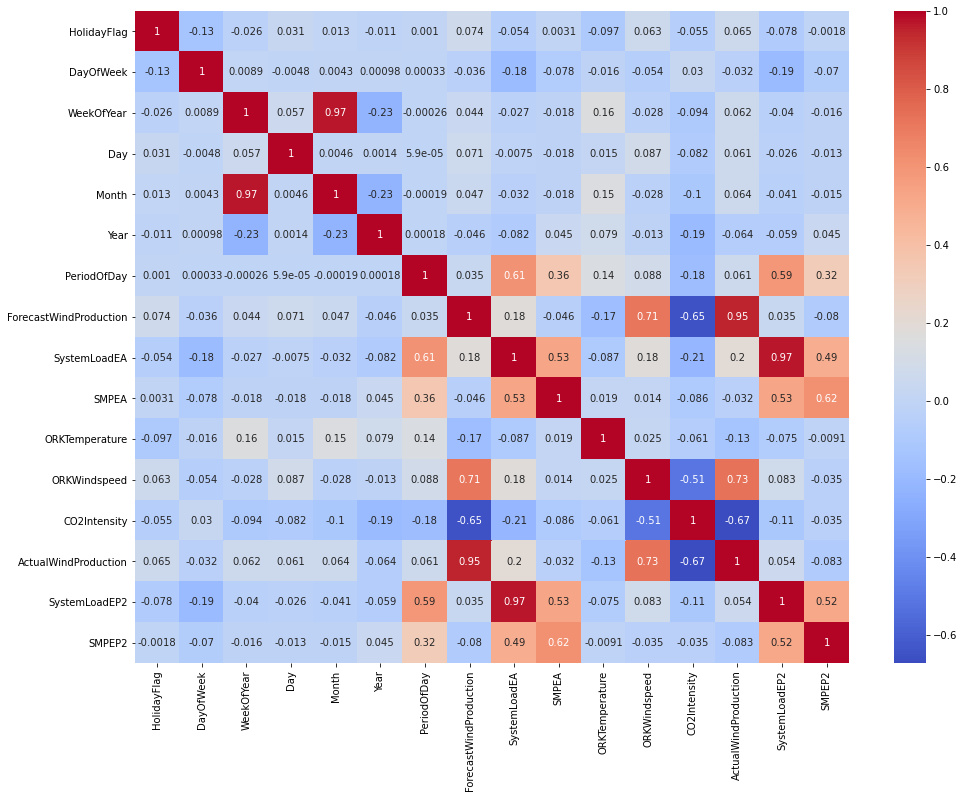

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
correlations = data.corr(method='pearson')
plt.figure(figsize=(16, 12))
sns.heatmap(correlations, cmap="coolwarm", annot=True)
plt.show()

In [26]:
x = data[["Day", "Month", "ForecastWindProduction", "SystemLoadEA", 
          "SMPEA", "ORKTemperature", "ORKWindspeed", "CO2Intensity", 
          "ActualWindProduction", "SystemLoadEP2"]]
y = data["SMPEP2"]
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, 
                                                test_size=0.2, 
                                                random_state=42)

In [27]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(xtrain, ytrain)
model.score(xtest, ytest)

0.5387290584438358

In [28]:
#features = [["Day", "Month", "ForecastWindProduction", "SystemLoadEA", "SMPEA", "ORKTemperature", "ORKWindspeed", "CO2Intensity", "ActualWindProduction", "SystemLoadEP2"]]
features = np.array([[0, 350.0, 54.10, 4241.05, 49.56, 9.0, 14.8, 491.32, 54.0, 4426.84]])
model.predict(features)

array([66.6915])